# IMPLÉMENTATION D'UN VAE SUR LE DOMAINE MNIST

Dans ce notebook j'implémente un VAE sur le domaine MNIST. Dans le rapport PDF également présent dans le repo je rappele dans les grandes lignes la théorie des VAE avant d'en proposer ici une implémentation rapide et commentée sur le domaine MNIST. 

Ce notebook reprend plusieurs tutoriels disponibles en suivant ces liens : 
- [Building a convolutional VAE in Pytorch](https://towardsdatascience.com/building-a-convolutional-vae-in-pytorch-a0f54c947f71)
- [Getting Started with VAE using Pytorch](https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/)
- [VAE with Pytorch](https://avandekleut.github.io/vae/)

# I) Lecture des données

In [193]:
# packages de base
import numpy as np

# packages Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# datasets
from torchvision import datasets, transforms
from torchvision.utils import save_image

# visualisation
import matplotlib.pyplot as plt
from tqdm import tqdm

# gestion des fichiers
import os as os

On utilise le jeu de données MNIST qui comprend 70 000 images représentant des chiffres calligraphiés entre 0 et 9. 

On va importer les données dans des dataloaders en spécifiant une taille de batch pour le jeu d'entraînement. Chaque élément du dataloader sera un batch comprenant les inputs (28*28 pixels) et l'output (chiffre calligraphié). 

In [2]:
batch_size=128

In [59]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True,transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transforms.ToTensor()),batch_size=batch_size)

X contains 128 elements
The size of each element (input) is : torch.Size([1, 28, 28]) 

y also contains 128 elements
The size of each element (output) is : torch.Size([]) 



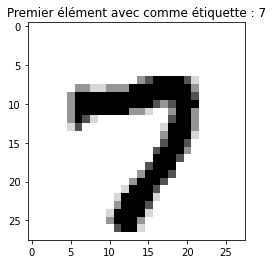

In [60]:
# on peut inspecter les données (données pour chaque batch)
for element in train_loader:
    print('X contains {} elements'.format(len(element[0])))
    print('The size of each element (input) is : {} \n'.format(element[0][0].shape))
    print('y also contains {} elements'.format(len(element[1])))
    print('The size of each element (output) is : {} \n'.format(element[1][0].shape))
    plt.imshow(element[0][0].reshape(28,28),cmap='Greys')
    plt.title('Premier élément avec comme étiquette : {}'.format(element[1][0]))
    break

# II) Architecture du VAE 

On définit l'architecture de notre VAE. 
- L’encodeur comprend deux couches de convolutions, suivies par deux couches entièrement connectées. En sortie on obtiendra moyenne et variance de la loi à simuler. 
- À partir de cette moyenne et de cette variance on peut simuler aléatoirement un point de la distribution qui sera donnée en entrée du décodeur. 
- Enfin, le décodeur comprend une couche entièrement connectée puis deux couches de convolution. 

In [61]:
class VAE (torch.nn.Module):
    def __init__(self, imgChannels, featureDim, latent_dim):
        '''super permet de faire hériter à cette nouvelle classe
        toutes les méthodes de la class torch.nn.Module'''
        super(VAE,self).__init__()
        
        ''' Dans le constructeur on instancie tous les modules dont 
        on aura besoin par la suite'''
        
        '''POUR L ENCODEUR'''
        # première couche de convolution - on obtient 16 couches de sorties
        # avec des noyaux 5*5 et un stride de 1 - on obtiendra des images en 24*24
        self.encConv1=nn.Conv2d(in_channels=imgChannels,out_channels=16,kernel_size=5,stride=1, groups=1)
        
        # deuxième couche de convolution - on obtient 32 couches de sorties
        # avec des noyaux 5*5 et un stride de 1 - on obtiendra des images en 20*20
        self.encConv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1)
        
        # couches entièrement connectées qui donneront moyenne et variances
        self.encFC1=nn.Linear(in_features=featureDim, out_features=latent_dim)
        self.encFC2=nn.Linear(in_features=featureDim, out_features=latent_dim)
       
        '''POUR LE DECODEUR'''
        # Couches pour le décodeur (inverse des couches de l'encodeur)
        self.decFC1 = nn.Linear(latent_dim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
 
    
    def encoder(self,x):
        x=F.relu(self.encConv1(x)) #1ère convolution
        x=F.relu(self.encConv2(x)) #2ème convolution
        x=x.view(-1,32*20*20) # on change la taille du tenseur
        mu=self.encFC1(x) #moyenne de la normale
        logVar=self.encFC2(x) #logarithme de la variance de la normale
        return mu,logVar
    
    def reparametrize(self,mu,logVar):
        '''Cette fonction applique le "reparametrization trick" spécifique aux VAE'''
        std=torch.exp(logVar/2)
        eps=torch.randn_like(std)
        return mu + std*eps
    
    def decoder(self,z):
        x=F.relu(self.decFC1(z))
        x=x.view(-1,32,20,20)
        x=F.relu(self.decConv1(x))
        x=torch.sigmoid(self.decConv2(x))
        return x
        
    
    def forward(self,x):
        '''Dans la fonction forward on ré-utilise les modules définis en init
        ainsi que les fonctions définies au préalable. On ne définit que le forward
        le backward sera directement calculé par différenciation automatique'''
        mu,logVar=self.encoder(x)
        z=self.reparametrize(mu,logVar)
        out=self.decoder(z)
        return out,mu,logVar

# III) Entraînement du modèle

In [62]:
# on paramètre le device selon la disponibilité d'un GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
print('Le modèle tourne actuellement sur '+str(device))

Le modèle tourne actuellement sur cpu


In [135]:
# on instancie le modèle avec les paramètres souhaités
imgChannels=1
featureDim=32*20*20
latentDim=256

vae_model=VAE(imgChannels,featureDim,latentDim).to(device)

On peut désormais passer à l'entraînement du modèle qu'on va structurer sous la forme d'une fonction. 

La fonction de perte utilisée se décompose de la façon suivante : 

- L’erreur de reconstruction est calculée sur chacun des pixels : 
$$ R(X,X')=\sum_{i=1}^{n} x_i' \times log⁡(x_i) + (1-x_i') \times log⁡(1-x_i) $$

- La divergence de Kullbach-Leibler est calculée à partir des paramètres de la loi normale et doit être minimisée : $$D_{KL} [q_\phi (z|x_i ) || p_\theta (z)]=-1/2 \sum_{i=1}^m -\sigma_i^2- μ_i^2+log⁡(\sigma_i^2) +1$$

In [156]:
'''Boucle d entrainement'''
def fit_and_validate(model,epochs,lr=1e-3):
    '''model : modèle à entraîner
    epochs : nombre d époques
    lr : learning rate '''
    
    # on va stocker les pertes sur le jeu d'entraînement et de test
    train_loss = []
    val_loss = []
    
    # Adam : descente de gradient stochastique avec pénalisation des poids élevés du réseau
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        # calcul de la perte sur le jeu d'entraînement
        train_epoch_loss = fit(model, train_loader,optimizer=optimizer)
        
        # calcul de la perte sur le jeu de test
        val_epoch_loss = validate(model, test_loader,epoch)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}")
    return(train_loss,val_loss)

In [154]:
'''La fonction fit correspond à l entrainement sur une époque donnée'''
def fit(model, dataloader,optimizer):
    # on se met en mode train
    model.train()
    
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        img, _ = data
        img = img.to(device)
        
        # on remet le gradient à zéro
        optimizer.zero_grad()
        
        #forward pass
        out,mu,logVar=model(img)

        # on calcule la perte
        kl_div=-torch.sum(1 + logVar-mu.pow(2)-logVar.exp())*0.5
        rec_loss=F.binary_cross_entropy(out, img, reduction='sum') 
        total_loss=rec_loss+kl_div
        running_loss += total_loss.item()
        
        # on applique un pas de descente de gradient
        total_loss.backward()
        optimizer.step()
        
    # perte finale (moyenne pour un échantillon)    
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [155]:
'''La fonction validate correspond au calcul de la perte sur le jeu de test indépendant pour une époque donnée'''
def validate(model, dataloader,epoch):
    # on passe en mode eval
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            img, _ = data
            img = img.to(device)
            
            # forward
            out,mu,logVar=model(img)
            
            # calcul de la perte
            kl_div=-torch.sum(1 + logVar-mu.pow(2)-logVar.exp())*0.5
            rec_loss=F.binary_cross_entropy(out, img, reduction='sum') 
            total_loss=rec_loss+kl_div
            running_loss += total_loss.item()
            
            # on sauvegarde les images et leurs reconstructions
            # pour l'avant-dernier batch de chaque époque 
            # (on ne prend pas l'avant dernier batch dont la taille pourrait différer)
            if idx == int(len(dataloader)) - 2:
                print('id',idx)
                both = torch.cat((img.view(dataloader.batch_size, 1, 28, 28)[:8], 
                                  out.view(dataloader.batch_size, 1, 28, 28)[:8]))
                PATH="outputs/output{}.png".format(epoch)
                print('')
                save_image(both,PATH)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

Maintenant que ces fonctions ont été définies on peut entraîner le modèle. 

In [157]:
train_loss,val_loss=fit_and_validate(vae_model,10)

Epoch 1 of 10
id 77

Train Loss: 113.9079
Val Loss: 110.3106
Epoch 2 of 10
id 77

Train Loss: 109.7569
Val Loss: 108.1393
Epoch 3 of 10
id 77

Train Loss: 107.8366
Val Loss: 106.3780
Epoch 4 of 10
id 77

Train Loss: 106.6471
Val Loss: 105.5707
Epoch 5 of 10
id 77

Train Loss: 105.7303
Val Loss: 104.8429
Epoch 6 of 10
id 77

Train Loss: 105.0702
Val Loss: 104.2633
Epoch 7 of 10
id 77

Train Loss: 104.5320
Val Loss: 103.5819
Epoch 8 of 10
id 77

Train Loss: 104.0992
Val Loss: 103.1979
Epoch 9 of 10
id 77

Train Loss: 103.6731
Val Loss: 103.0709
Epoch 10 of 10
id 77

Train Loss: 103.3970
Val Loss: 102.8423


On peut tracer les courbes d'évolutions de perte sur le jeu d'entraînement et le jeu de test. 

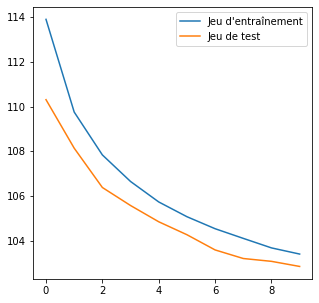

In [161]:
plt.figure(figsize=(5,5))
plt.plot(train_loss,label="Jeu d'entraînement")
plt.plot(val_loss,label="Jeu de test")
plt.legend()
plt.show()

On sauvegarde le modèle pour éviter de devoir à nouveau le ré-entraîner par la suite. 

In [77]:
PATH='vae_model.pth'
torch.save(vae_model.state_dict(), PATH)

Si besoin est on pourra ainsi re-télécharger le modèle pré-entraîné de la manière suivante : 

In [78]:
model = VAE(imgChannels,featureDim,latentDim).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (encFC1): Linear(in_features=12800, out_features=256, bias=True)
  (encFC2): Linear(in_features=12800, out_features=256, bias=True)
  (decFC1): Linear(in_features=256, out_features=12800, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)

# IV) Vérifications sur le modèle entraîné

## A) Reconstructions sur le jeu de test

On peut regarder les résultats des reconstructions sur le jeu de test (obtenus lors de l'entraînement).  

In [158]:
def print_results(i):
    PATH='outputs/output{}.png'.format(i)
    data=plt.imread(PATH)
    plt.imshow(data)
    plt.axis('off')
    plt.title("Reconstruction à l'époque n*{}".format(i))
    plt.show()

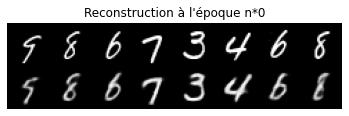

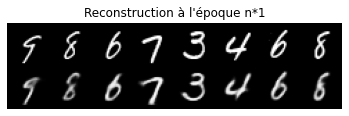

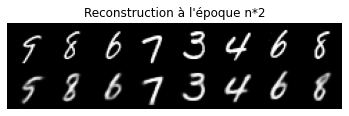

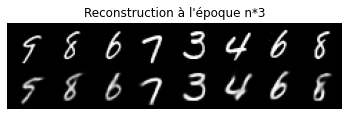

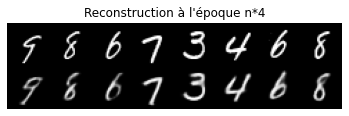

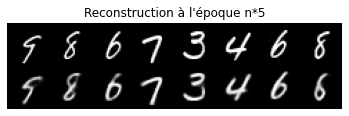

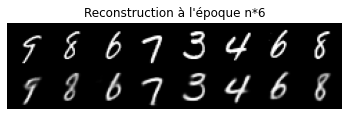

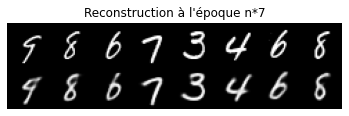

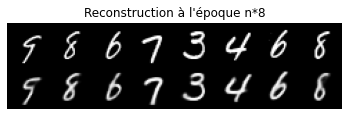

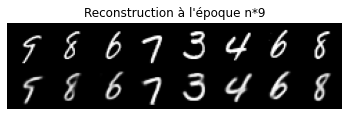

In [160]:
epochs=10
for i in range(epochs):
    print_results(i)

On constate que les reconstructions sont de bonne qualité et semblent s'améliorer au fur et à mesure de l'entraînement.

## B) Interpolations dans l'espace latent

On peut ensuite construire des interpolations dans l'espace latent. On va partir de deux éléments du domaine MNIST, les projeter dans l'espace latent puis visualiser les interpolations entre ces deux éléments. 

In [319]:
def interpolate(autoencoder, x1=1, x2=9, n=12):
    '''Ce modèle prend en entrée l auto-encodeur
    x1,x2 sont deux images issues du jeu de données sur lesquelles on va pratiquer une interpolation
    On peut sélectionner le chiffre souhaité
    12 est le nombre d'images que l'on veut récuperer
    '''
    # on choisit deux inputs du domaine MNIST dans le premier batch
    # on récupère un batch
    x, y = train_loader.__iter__().next()

    # on restructure nos données
    x_1=x[y==x1][1]
    x_2=x[y==x2][1]
    x_1=x_1.reshape((1,1,28,28))
    x_2=x_2.reshape((1,1,28,28))

    # on récupère les versions encodés des deux inputs
    z_1 = autoencoder.encoder(x_1)[0]
    z_2 = autoencoder.encoder(x_2)[0]
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Interpolation dans l'espace latent entre {} et {}".format(x1,x2))
    plt.show()

On construit ces interpolations pour différents couples de chiffres. Le résultat semble plutôt satisfaisant en terme de continuité de l'espace latent. 

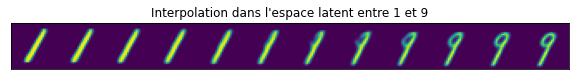

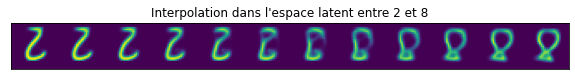

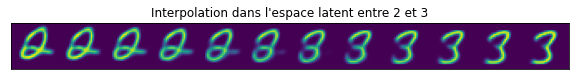

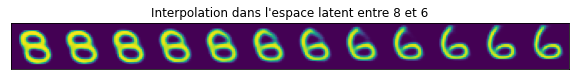

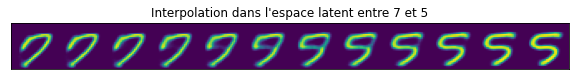

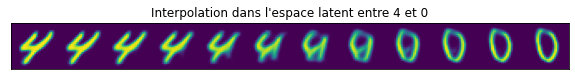

In [322]:
interpolate(vae_model, 1, 9, n=12)
interpolate(vae_model, 2, 8, n=12)
interpolate(vae_model, 2, 3, n=12)
interpolate(vae_model, 8, 6, n=12)
interpolate(vae_model, 7, 5, n=12)
interpolate(vae_model, 4, 0, n=12)

## C) Simulations à partir de l'espace latent

On va maintenant simuler dans l'espace latent (à partir d'une gaussienne $\mathcal{N}(0,1)$) et observer si les résultats ressemblent au domaine souhaité. 

In [313]:
def sim_from_latent_space(vae_model,mu=torch.zeros(256),logVar=torch.zeros(256)):
    std=torch.exp(logVar/2)
    eps=torch.randn_like(std)
    z=mu + std*eps
    
    with torch.no_grad():
        img=vae_model.decoder(z)
        img=img.reshape(28,28)
    return(img)

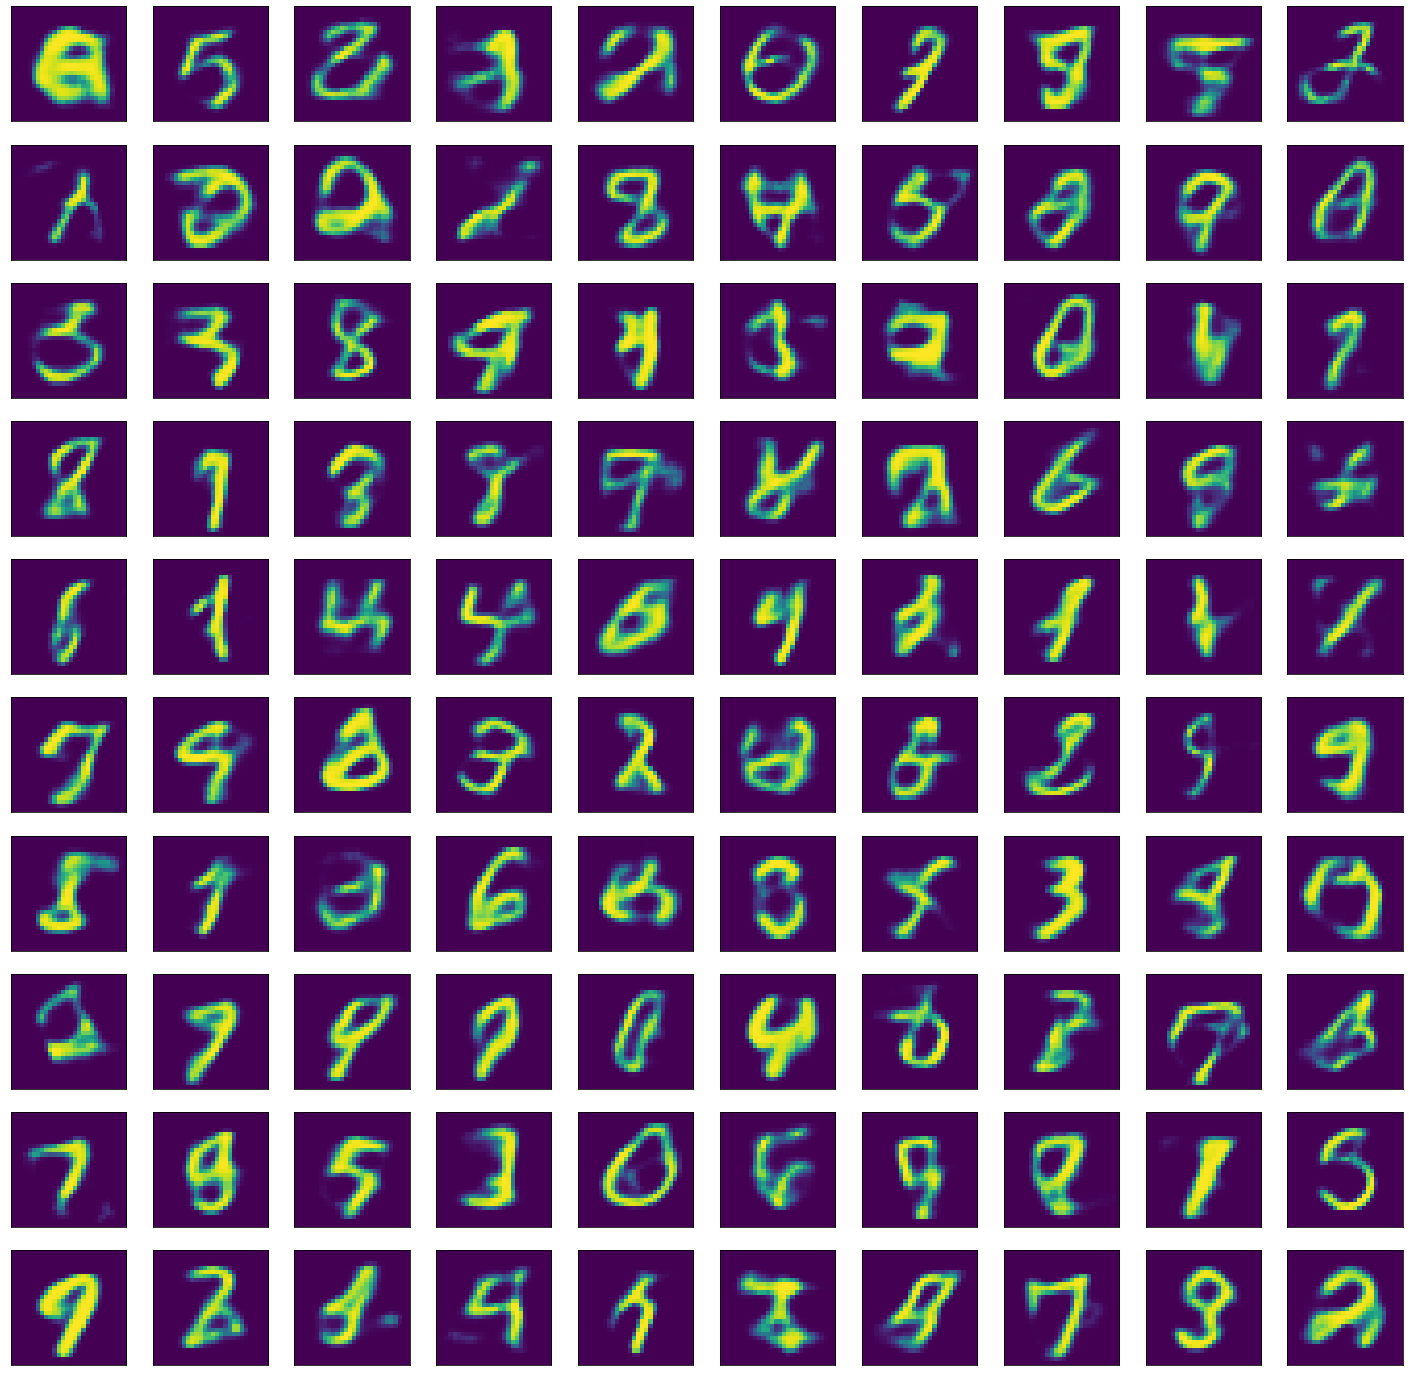

In [324]:
fig,axs=plt.subplots(nrows=10,ncols=10,figsize=(25,25))
for i in range(10):
    for j in range(10):
        ax=axs[i][j]
        img=sim_from_latent_space(vae_model)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
plt.show()

On constate que certains résultats sont assez flous voire incohérents avec le domaine MNIST mais que dans l'ensemble les images obtenus sont en phase avec le domaine cible. D'autre part l'intégralité des chiffres entre 0 et 9 peuvent être retrouvés ce qui nous rassure sur la représentativité de l'espace latent.  